In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from torch import optim
import json
from PIL import Image
import io
import cv2
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
import tqdm
import time
import os
import copy
import pickle
import urllib.request
import requests
from matplotlib.pyplot import imshow
import random

In [2]:
#Helper Functions
def imshow_tensor(img):
    img = inv_normalize(img)     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def saveim(img, name):
    img = inv_normalize(img.cpu())
    save_image(img, name)
def readim(name):
    image = Image.open(name)
    x = TF.to_tensor(image)
    x = forward_normalize(x)
    x.unsqueeze_(0)
    return x
def stack(w,size):
    dim = len(torch.flatten(w)) // 3
    if dim == size:
        return w
    ide = torch.eye(dim, requires_grad=True, dtype=torch.float, device=device)
    zer = torch.zeros([1,dim], requires_grad=True, dtype=torch.float, device=device)

    n = size // dim
    m = size % dim
    nsum = torch.zeros([1,size,3], requires_grad=True, dtype=torch.float, device=device)
    ides = torch.cat(n*[ide])
    if m != 0:
        zers = torch.cat(m*[zer])
        mat = torch.cat([ides,zers])
    else:
        mat = ides
    w2 = w.view([1,dim,3])
    nsum = nsum + torch.matmul(mat,w2)
    if m == 0:
        return nsum.view([3,size,1])
    t = []
    for i in range(m):
        t.append(torch.tensor([1 if x == i else 0 for x in range(dim)],requires_grad=True, dtype=torch.float, device=device))
    mat2 = torch.cat([torch.cat(dim*n*[zer]),torch.stack(t)])
    nsum = nsum + torch.matmul(mat2,w2)
    return nsum.view([3,size,1])
def shift_operation(w,offset):
    dim = len(torch.flatten(w))//3
    ide = torch.eye(dim, device=device)
    for i in range(dim):
        ide[i][i] = 0
        ide[(i+offset)%dim][i] = 1
    return torch.matmul(ide,w)
def gamma_correction(img, factor):
    return ((img+0.5)**factor)-0.5
def scale_operation(w, scale):
    dim = len(torch.flatten(w))
    n_dim = int(dim/scale)
    w = w.unsqueeze(0)
    t = nn.Upsample(size=(dim,1), mode='bilinear')
    n_w = t(w[:,:,:n_dim])
    return n_w[0]
def split(inp,chan):
    size = inp[0].shape
    inp2 = copy.deepcopy(inp.detach())
    for i in range(len(inp)):
        if i != chan:
            inp2[i] = torch.zeros(size)
    return inp2

In [3]:
def imstats(name):
    x = readim(name)
    imshow_tensor(x[0])

    prob = lay2(pretrained_model(x.cuda()))
    maxcls = prob.max(1)
    print("Class is {} ({}) with confidence {}%".format(maxcls.indices.item(),class_dict[maxcls.indices.item()],round(maxcls.values.item()*100,4)))

(1200, 1296)


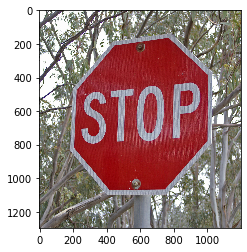

In [28]:
CLASS_URL = 'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'
class_dict = pickle.load(urllib.request.urlopen(CLASS_URL))

IMG_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/STOP_sign.jpg/1200px-STOP_sign.jpg"
classidx = 919
response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))
print(img.size)
imshow(img)

In [29]:
model_img_size = 224
model_transform = transforms.Compose([transforms.Resize((model_img_size,model_img_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
forward_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

print(type(img))
img_input = model_transform(img)
#img_input = img_input.unsqueeze(0)
#img_input = Variable(img_input)
img_input.shape

<class 'PIL.JpegImagePlugin.JpegImageFile'>


torch.Size([3, 224, 224])

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model = models.resnet101(pretrained=True)
pretrained_model.to(device)
pretrained_model.eval()
img_input = img_input.to(device)
pred = pretrained_model(img_input.unsqueeze(0))
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(pred)
maxOcls = prob.max(1)
print("Class is {} ({}) with confidence {}%".format(maxOcls.indices.item(),class_dict[maxOcls.indices.item()],maxOcls.values.item()*100))

Class is 919 (street sign) with confidence 99.44760203361511%


<class 'torch.Tensor'>


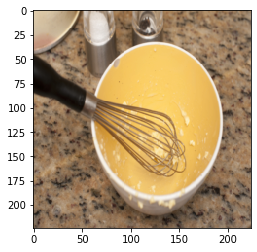

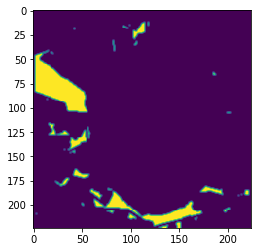

In [26]:
def get_object_mask(input_image):
    #print(test[-3][:])
    test = inv_normalize(input_image)
    test = np.uint8(test.numpy()*255).transpose((1,2,0))
    #test = 1 - test
    #test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(test, cv2.COLOR_RGB2GRAY)
    th, thgray = cv2.threshold(gray, 75, 255, cv2.THRESH_BINARY_INV); 
    #blurred = cv2.GaussianBlur(thgray, (9, 9), 0)
    th, blurred = cv2.threshold(thgray, 50, 255, cv2.THRESH_BINARY); 
    edged = cv2.Canny(blurred, 1, 250, L2gradient=True)   
    #imgplot = plt.imshow(blurred, cmap="gray")
    #plt.show()
    #imshow(input_image[0])
    #applying closing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)    #finding_contours
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   
    #cnts = [] #only for plate class 
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        cv2.drawContours(closed, [approx], -1, (0, 255, 0), 2)    
    th, im_th = cv2.threshold(closed, 254, 255, cv2.THRESH_BINARY_INV);    
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 0);    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)    # Combine the two images to get the foreground.
    #imshow(im_th)
    #plt.show()
    #imshow(im_floodfill_inv)
    #plt.show()
    im_out = im_th ^ im_floodfill_inv
    im_out = cv2.GaussianBlur(im_out, (3, 3), 0)
    return im_out
print(type(img_input))
imshow_tensor(img_input.cpu())
imgplot = plt.imshow(get_object_mask(img_input.cpu()))
plt.show()

In [18]:
adv = [598, 697, 898, 567, 69, 855, 641, 600, 942]
fold = "c0.3_sz228_shiftF/"
#targidx = np.random.randint(0,1000)
targidx = adv[1]
print(targidx)

697


In [9]:
# The input time signal
sz = 130
c = .5
w = torch.rand([3,sz,1], requires_grad=True, dtype=torch.float, device=device)
#Does not work since no useful gradients
#Aw = torch.rand([1], requires_grad=True, dtype=torch.float, device=device) #amplitude and frequency
#sample = torch.linspace(0, 4, sz, dtype=torch.float, device=device)  #Sampling rate, do the math to get this
#w = torch.sin(100*Aw[0]*sample).view([1,1,sz,1]) #Sample the sine wave

mask = torch.tensor(get_object_mask(img_input.cpu()), dtype=torch.float, device=device)
mask = mask / torch.max(mask)
#The shutter function is encoded into the convolution layer
lay = torch.nn.Conv1d(1,1,5)

#Manually setting the weights and bias so the  shutter acts as a box filter
lay.weight.data = torch.full([1,1,5,1], .2, requires_grad=True, dtype=torch.float, device=device)
lay.bias.data = torch.zeros(1, requires_grad=True, dtype=torch.float, device=device)

#Target and original class labels
target = torch.tensor([targidx], dtype=torch.long, device=device)
orig = torch.tensor([classidx], dtype=torch.long, device=device)


lr = 1e-1
n_epochs = 1000
optimizer = optim.SGD([w], lr=lr)
loss_fn = nn.CrossEntropyLoss()

Switching from untarget to target 448



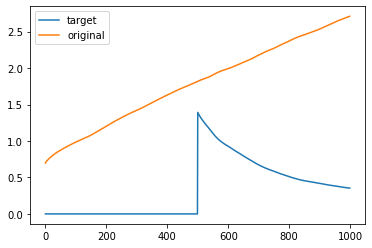

In [11]:
targloss = []
origloss = []
for epoch in tqdm.tqdm_notebook(range(n_epochs)):
    half = epoch < n_epochs/2
    if epoch == n_epochs/2:
        tops = out.topk(2).indices[0]
        targidx = tops[0].item() if tops[0].item() != classidx else tops[1].item()
        target = torch.tensor([targidx], dtype=torch.long, device=device)
        print("Switching from untarget to target {}".format(targidx))
    # Compute g(y) to get X_adv
    #print(w.shape)
    oot = stack(w,228)
    #oot = shift_operation(oot, np.random.randint(0,228))
    #oot = scale_operation(oot, np.random.rand(1)[0]+1)
    new_w = .5 * (torch.tanh(oot) + 1)
    gy = lay(new_w.unsqueeze(0).view([3,1,228,1])).view([1,3,224,1])[0]             #Convolution of ft and the shutter
    gy_mask = gy * mask
    #gy_mask = gy_mask + (1 - mask)
    inp = ((1-mask) + mask*(c + (1-c)*gy_mask))*inv_normalize(img_input)         #gy is broadcasted to match the shape of input_im
    inp = forward_normalize(inp)
    out = pretrained_model(inp.unsqueeze(0))
    #Calculate Loss
    if not half: targLoss = loss_fn(out, target)
    origLoss = loss_fn(out, orig)
    loss = -origLoss if half else targLoss
    targloss.append(0 if half else targLoss)
    origloss.append(origLoss)
    loss.backward()
    
    
    optimizer.step()
    
    optimizer.zero_grad()
    
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()

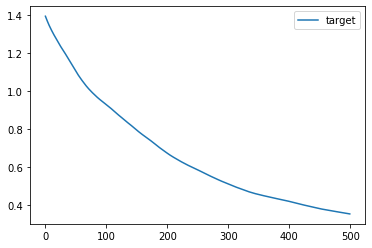

In [12]:
plt.plot(targloss[n_epochs//2:], label="target")
plt.legend()
plt.show()

In [13]:
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(out)
maxcls = prob.max(1)
print(prob[0][targidx])
print(prob[0][classidx])
print("Class is {} ({}) with confidence {}%".format(maxcls.indices.item(),class_dict[maxcls.indices.item()],maxcls.values.item()*100))

tensor(0.7020, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0665, device='cuda:0', grad_fn=<SelectBackward>)
Class is 448 (birdhouse) with confidence 70.20375728607178%


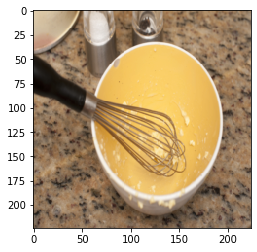

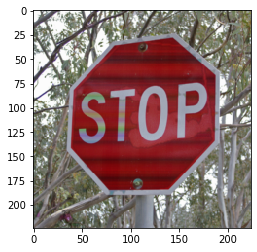

In [27]:
imshow_tensor(img_input.cpu())
imshow_tensor(inp.detach().cpu())

saveim(img_input, "original_{}.png".format(classidx))
saveim(inp, "src{}_c{}_sz{}_tg{}.png".format(classidx,c,sz,targidx))

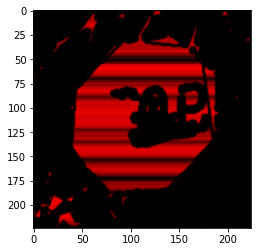

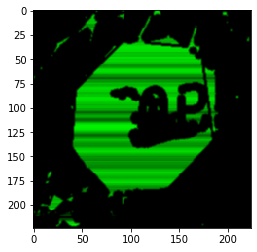

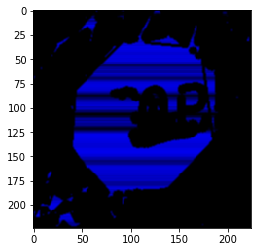

In [15]:
test = torch.ones([3,224,224], device=device)
re = test * split(gy_mask,0)
gr = test * split(gy_mask,1)
bl = test * split(gy_mask,2)
imshow_tensor(forward_normalize(re.detach().cpu()))
imshow_tensor(forward_normalize(gr.detach().cpu()))
imshow_tensor(forward_normalize(bl.detach().cpu()))

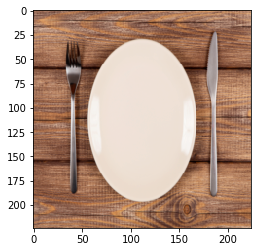

Class is 923 (plate) with confidence 16.4342%


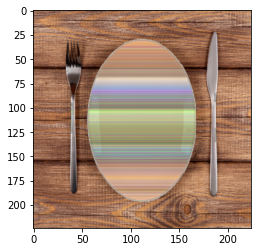

Class is 598 (home theater, home theatre) with confidence 31.2414%


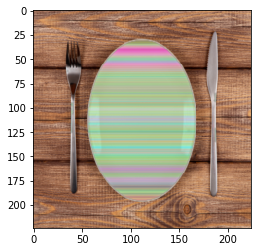

Class is 697 (pajama, pyjama, pj's, jammies) with confidence 32.1367%


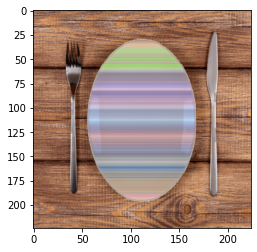

Class is 898 (water bottle) with confidence 47.841%


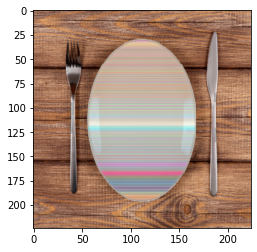

Class is 567 (frying pan, frypan, skillet) with confidence 32.0901%


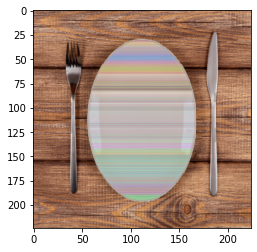

Class is 69 (trilobite) with confidence 26.628%


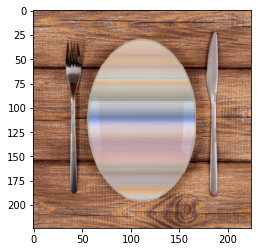

Class is 855 (thimble) with confidence 36.929%


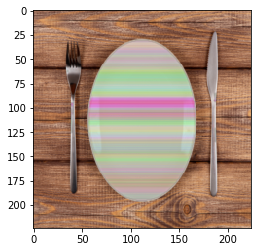

Class is 641 (maraca) with confidence 92.4983%


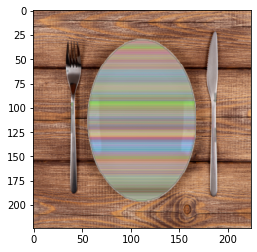

Class is 600 (hook, claw) with confidence 85.5116%


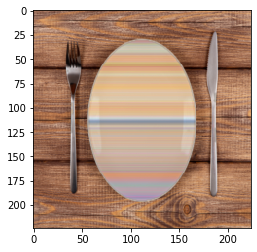

Class is 942 (butternut squash) with confidence 75.143%


In [19]:
imstats("original_923.png")
for i in adv:
    imstats("{}adv_{}.png".format(fold,i))